# Imports

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.utils import shuffle

# Functions for Loading Training and Testing directories

In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

def dataDirectory(directory):
    directorys = []
    
    folder1 = os.listdir(directory)

    for Folder1 in folder1:
        directoryGestos = os.path.join(directory, Folder1)
        folder2 = os.listdir(directoryGestos)

        for Folder2 in folder2:
            directoryFirmante = os.path.join(directoryGestos, Folder2)
            #folder3 = sorted_alphanumeric(os.listdir(directoryFirmante))
            folder3 = os.listdir(directoryFirmante)

            for Folder3 in folder3:
                directoryFirmanteFrame = os.path.join(directoryFirmante, Folder3)
                directorys.append(directoryFirmanteFrame)
                
    return sorted_alphanumeric(directorys)

# Functions for data preprocessing

In [4]:
# Rescalado de la imagen 
def dataProcessing(data, width, height):  
    # dsize
    dsize = (width, height)
 
    # cambiar el tamaño de la image
    output = cv2.resize(data, dsize)
    
    return output 
    
# lectura y rescalado de la imagen 
def readData(directorys, width, height, tipoImg='RGB'):
    if tipoImg=='RGB':
        img = cv2.imread(directorys)
    if tipoImg=='Gray':
        img = cv2.imread(directorys,cv2.IMREAD_GRAYSCALE)
    #read image
    img = dataProcessing(img, width, height)
    
    return img

# Load the directories

In [5]:
directoryTrain = './DATEN/trainData/'
directoryTrainMask = './DATEN/trainMask/'

directoryTest = './DATEN/testData/'
directoryTestMask = './DATEN/testMask/'

directorysX = dataDirectory(directoryTrain)
directorysY = dataDirectory(directoryTrainMask)

directorysTestX = dataDirectory(directoryTest)
directorysTestY = dataDirectory(directoryTestMask)

# Functions to save Training and Test sets

In [6]:
# Funciones salvar los conjuntos de entrenamiento y test
def saveData(directorys,name="data.npy", tipoImg='RGB'):
    height = 192
    width = 192
    data = []
    
    for i in directorys:
        data.append(readData(i, width, height, tipoImg=tipoImg))
        
    np.save(os.path.join('./working/', name), data)

# Load, process and save the Train and Test sets

In [7]:
saveData(directorysX,name="trainX.npy")
saveData(directorysY,name="trainY.npy", tipoImg='Gray')
saveData(directorysTestX,name="testX.npy")
saveData(directorysTestY,name="testY.npy", tipoImg='Gray')

# Load Training and test datasets

In [8]:
trainX = np.load('./working/trainX.npy')
trainY = np.load('./working/trainY.npy')

testX = np.load('./working/testX.npy')
testY = np.load('./working/testY.npy')

# Normalize Labels of Training and Test Data

In [9]:
# Normalizamos las etiquetas de entrenamiento y test en el rango de [0-1]
labelsTrain = (trainY>30)*1
labelsTest = (testY>30)*1

#Obtnemos cuantas clases unicas contiene las etiquetas de entrenaminto y test
classTrainY = np.unique(labelsTrain)
classTestY = np.unique(labelsTest)

# Plotting Images with its Mask

dimenciones de las imagenes:  (192, 192, 3)
numero de clases de las etiquetas:  2


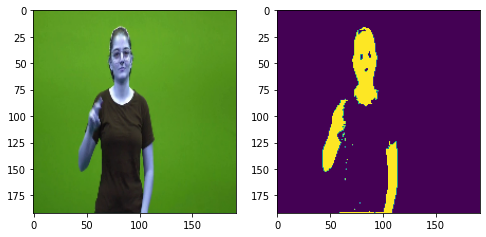

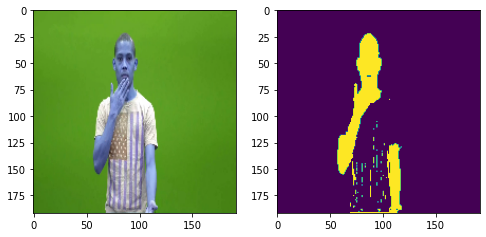

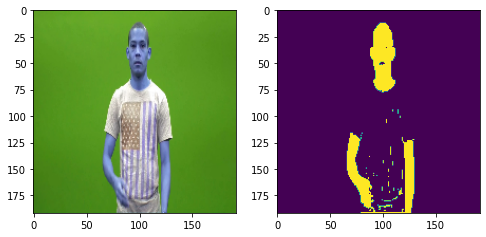

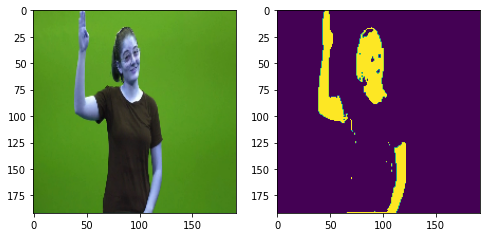

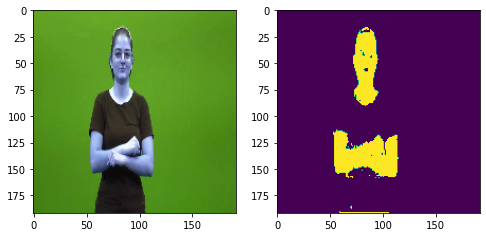

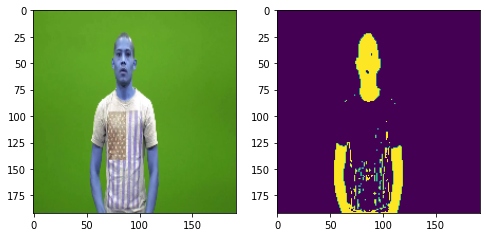

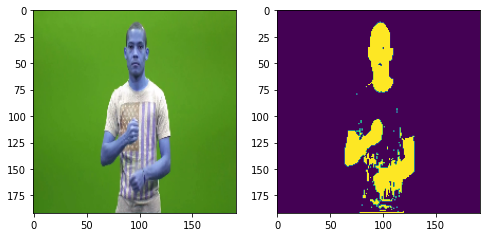

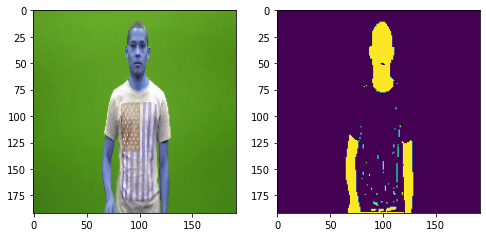

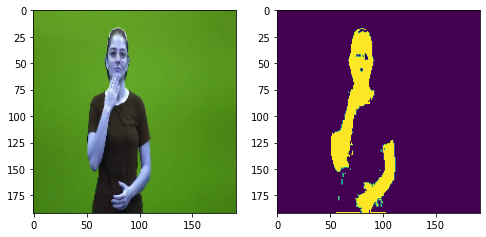

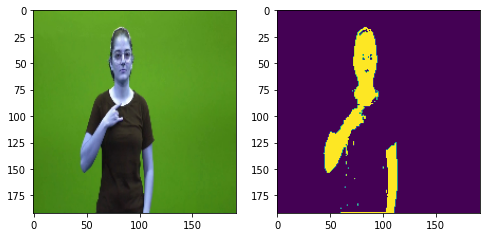

In [10]:
# Dimemeciones de las imagenes
imgDimensions = trainX[0].shape
print("dimenciones de las imagenes: ", imgDimensions)
print("numero de clases de las etiquetas: ", len(classTrainY))

# mostramos los primeros 10 datos
for i in range(10):
    indexRandom = int(np.random.randint(trainX.shape[0], size=1))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(trainX[indexRandom])
    plt.subplot(1, 2, 2)
    plt.imshow(labelsTrain[indexRandom])
    plt.show()

# Defining the Convolutional model of type Unet
### Encoder

In [11]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True, name=''):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob, name=name)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

### Decoder

In [12]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

# The entire Unet

In [13]:
def UNetCompiled(input_size=imgDimensions, n_filters=32, n_classes=len(classTrainY)):
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False,name="my_layer_cod") 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    layer_cod = tf.keras.layers.Flatten(name="flatt")(cblock4[0])
    # Define the model
    bottleneck = tf.keras.Model(inputs=inputs, outputs=cblock4[0])
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model,  bottleneck

# Unet and Bottleneck

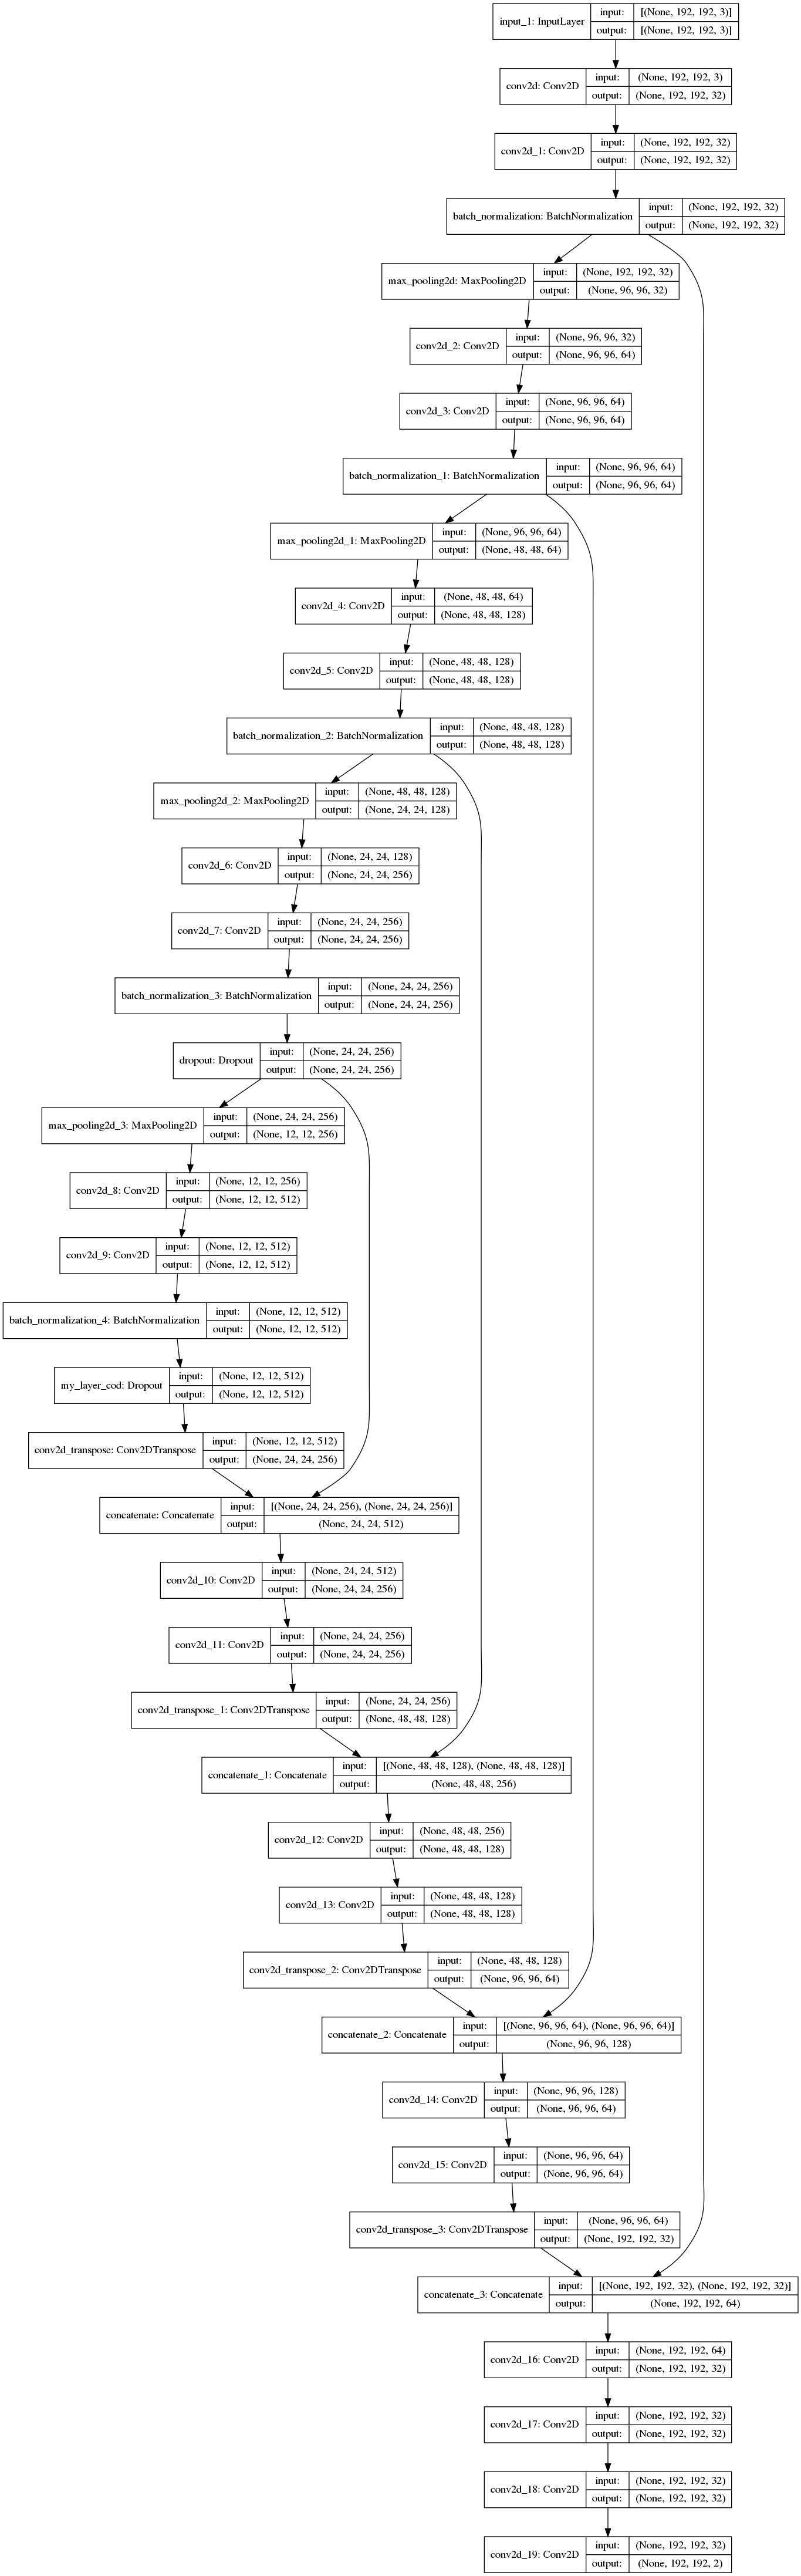

In [14]:
[unet, bottleneck] = UNetCompiled(input_size=imgDimensions, n_filters=32, n_classes= len(classTrainY))
tf.keras.utils.plot_model(unet, show_shapes=True)

# Number of layers of the Bottleneck and entire Unet 

In [15]:
print(len(unet.layers))
print(len(bottleneck.layers))

40
18


# Chart Backbone Structure

In [16]:
bottleneck.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        36928 

### Unet model weights

In [17]:
unet.layers[1].get_weights()

[array([[[[ 9.22561139e-02,  3.87520716e-02,  1.77215263e-01,
           -8.59935880e-02, -4.04440880e-01, -9.80840251e-02,
           -9.24841240e-02,  6.48477525e-02,  1.06773928e-01,
           -2.55972017e-02,  2.94012457e-01, -1.03399366e-01,
           -4.79833841e-01,  7.06489161e-02,  1.73202515e-01,
           -3.76764536e-01, -2.82332510e-01, -6.21264316e-02,
            3.80738437e-01, -1.68406144e-01, -1.41359523e-01,
            6.67867959e-02, -7.21423477e-02,  2.27443025e-01,
            1.75558478e-02,  2.38558993e-01,  1.71373427e-01,
           -3.36129159e-01, -3.17421764e-01, -1.48366794e-01,
            1.38260439e-01, -6.71714023e-02],
          [-4.53313708e-01, -6.39496595e-02,  2.51081605e-02,
            3.37967604e-01, -3.01099926e-01,  6.83576167e-02,
           -1.78201497e-01, -4.14730012e-01, -3.61117154e-01,
           -2.58222699e-01,  4.76731956e-01, -3.55104595e-01,
           -3.50644529e-01,  5.43867588e-01, -2.35686496e-01,
           -4.36293483e-

### Bottleneck model weights

In [18]:
bottleneck.layers[1].get_weights()

[array([[[[ 9.22561139e-02,  3.87520716e-02,  1.77215263e-01,
           -8.59935880e-02, -4.04440880e-01, -9.80840251e-02,
           -9.24841240e-02,  6.48477525e-02,  1.06773928e-01,
           -2.55972017e-02,  2.94012457e-01, -1.03399366e-01,
           -4.79833841e-01,  7.06489161e-02,  1.73202515e-01,
           -3.76764536e-01, -2.82332510e-01, -6.21264316e-02,
            3.80738437e-01, -1.68406144e-01, -1.41359523e-01,
            6.67867959e-02, -7.21423477e-02,  2.27443025e-01,
            1.75558478e-02,  2.38558993e-01,  1.71373427e-01,
           -3.36129159e-01, -3.17421764e-01, -1.48366794e-01,
            1.38260439e-01, -6.71714023e-02],
          [-4.53313708e-01, -6.39496595e-02,  2.51081605e-02,
            3.37967604e-01, -3.01099926e-01,  6.83576167e-02,
           -1.78201497e-01, -4.14730012e-01, -3.61117154e-01,
           -2.58222699e-01,  4.76731956e-01, -3.55104595e-01,
           -3.50644529e-01,  5.43867588e-01, -2.35686496e-01,
           -4.36293483e-

# Compiling and Training Convolutional Unet model

In [18]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['acc'])

In [19]:
unet_hitory = unet.fit(
                    trainX, 
                    labelsTrain, 
                    batch_size=37, 
                    epochs=10, 
                    verbose=1, 
                    validation_data=(testX, labelsTest)
)

Epoch 1/10
20/20 [==============================] - 151s 8s/step - loss: 19.2201 - acc: 0.8677 - val_loss: 1.0572 - val_acc: 0.9398
Epoch 2/10
20/20 [==============================] - 152s 8s/step - loss: 0.4639 - acc: 0.9475 - val_loss: 0.1276 - val_acc: 0.9783
Epoch 3/10
20/20 [==============================] - 154s 8s/step - loss: 0.1244 - acc: 0.9788 - val_loss: 0.0807 - val_acc: 0.9857
Epoch 4/10
20/20 [==============================] - 155s 8s/step - loss: 0.0894 - acc: 0.9832 - val_loss: 0.0680 - val_acc: 0.9867
Epoch 5/10
20/20 [==============================] - 154s 8s/step - loss: 0.0710 - acc: 0.9852 - val_loss: 0.0557 - val_acc: 0.9880
Epoch 6/10
20/20 [==============================] - 155s 8s/step - loss: 0.0572 - acc: 0.9868 - val_loss: 0.0451 - val_acc: 0.9892
Epoch 7/10
20/20 [==============================] - 156s 8s/step - loss: 0.0472 - acc: 0.9880 - val_loss: 0.0377 - val_acc: 0.9901
Epoch 8/10
20/20 [==============================] - 155s 8s/step - loss: 0.0403 - 

# save Convolutional Unet model

In [20]:
# save model
unet.save('./Models/UNet.hdf5')
print('Model Saved!')

Model Saved!


# Load Unet pre-trained model

In [22]:
# load model
pretrained_unet = load_model('./Models/UNet.hdf5')
pretrained_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 32) 128         conv2d_1[0][0]                   
____________________________________________________________________________________________

### Unet pre-trained model weights

In [23]:
pretrained_unet.layers[1].get_weights()

[array([[[[ 4.19075996e-01,  4.60303932e-01,  3.59098822e-01,
            7.62565881e-02, -8.35609287e-02, -2.63070047e-01,
            1.35382593e-01,  6.95741922e-02,  9.94799212e-02,
            1.11902148e-01,  2.30006531e-01,  9.30385664e-02,
            3.43607873e-01, -5.88154078e-01, -5.37429266e-02,
           -7.14294612e-02,  1.76052526e-01,  2.66519994e-01,
           -1.53233945e-01,  1.50518462e-01, -1.29123017e-01,
           -5.80009162e-01, -4.48826253e-01,  1.50317997e-01,
            6.08919382e-01,  5.30304074e-01, -2.85400808e-01,
            5.59187643e-02, -5.69378555e-01,  2.62269378e-01,
            6.00561440e-01, -2.20836163e-01],
          [ 1.83752015e-01,  2.31940508e-01,  3.02023619e-01,
           -3.77557054e-02,  1.37720510e-01, -3.58103365e-01,
            2.15304479e-01, -2.78875809e-02,  1.43221638e-03,
           -6.78709522e-02, -5.08922219e-01,  2.87359238e-01,
           -1.55027509e-01,  3.22587699e-01, -1.92096487e-01,
            2.82286733e-

# Transferring weights from the pre-trained to the Unet model

In [24]:
for index, layer in enumerate(pretrained_unet.layers):
    unet.layers[index].set_weights(layer.get_weights())

# Predicted Testing Mask Unet 

In [25]:
def VisualizeResults(index):
    img = testX[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(testX[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(labelsTest[index])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

# visualisation predicted Training mask by Unet

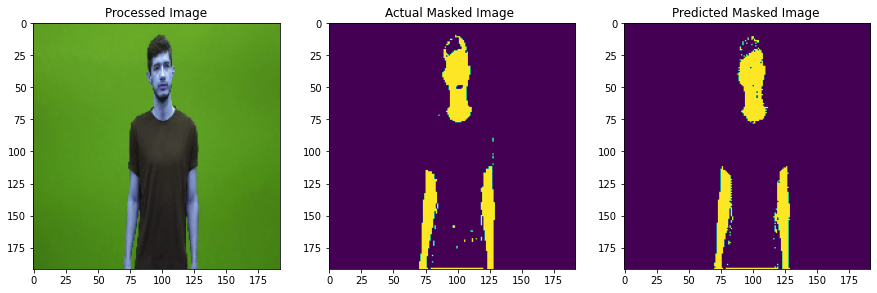

In [26]:
VisualizeResults(int(np.random.randint(testX.shape[0], size=1)))

# Predicted Training Mask Unet 

In [27]:
def VisualizeResults(index):
    img = trainX[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(trainX[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(labelsTrain[index])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

# visualisation predicted Training mask by Unet

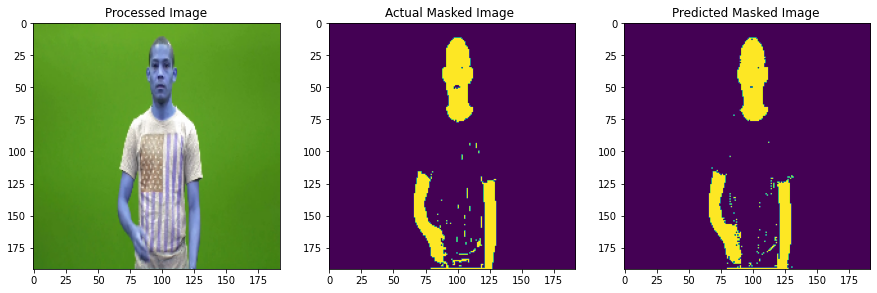

In [30]:
VisualizeResults(int(np.random.randint(trainX.shape[0], size=1)))

# Recurrent sequence model

In [32]:
# code to read images from a directory, resize them append them to an array and setup hyperparameters

PATH_DATA = './DATEN/'

CATEGORIES = ['beautiful', 'bye', 'goodafternoon', 'goodevening', 'hi', 'Iamsorry', 'name', 'thanks', 'UV', 'work'] 

IMG_SIZE_WIDTH = 192
IMG_SIZE_HEIGHT = 192
NUM_EPOCHS = 100
BATCH_SIZE = 30
TIME_STEP = 37
CHANNELS = 3
STRIDES = 2

# code to read images from a directory, resize them and add them to an array

def dataset_rgb(trial, data, label, IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT):
    global class_num
    for category in CATEGORIES:
        path = os.path.join(PATH_DATA + trial, category)
        class_num = CATEGORIES.index(category)
        for subdir in os.listdir(path):
            path_to_images = os.path.join(path, subdir)
            for img_name in sorted(os.listdir(path_to_images)):
                img_array = cv2.imread(os.path.join(path_to_images,img_name))
                new_array = cv2.resize(img_array, (IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT))
                data.append(new_array)
            label.append(class_num)

# Loading Training data

data_train = []
labels_train = []

dataset_rgb('trainRNN', data_train, labels_train, IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT)

X_train = np.array(data_train)
y_train = np.array(labels_train)

X_train = X_train.astype('float32')/255
y_train = to_categorical(y_train)

print(X_train.shape)
print(y_train.shape)

len(bottleneck.layers)

# Disable Batchnormalization Layers

# bottleneck.layers[3].trainable = False
# bottleneck.layers[7].trainable = False
# bottleneck.layers[11].trainable = False
# bottleneck.layers[15].trainable = False

# Disable all backbone Layers

# for layer in bottleneck.layers[:18]:
#     layer.trainable = False
    
# Backbone summary

bottleneck.summary()

# merging backbone (convolutional Unet model) and recurrent neural network model
def sequence_model():
    model = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(bottleneck, input_shape=(37, 192, 192, 3)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(CATEGORIES), activation='softmax')
    ])
    return model
model = sequence_model()
model.summary()

# compile the model and with the optimiser (Adam), loss function and the metrics (accuracy).

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ["acc"])

# Append data into 37-frame packets 
X_train = np.reshape(X_train, (100, 37, 192, 192, 3))
A, a = shuffle(X_train, y_train)
print(A.shape)
print(a.shape)

# callbacks and auto save best models
 
mcp_save = tf.keras.callbacks.ModelCheckpoint('./Modelos/model_1.0.hdf5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, mode='max', verbose=1)

# Training model with .fit

history = model.fit(A,
                    a,
                    epochs = NUM_EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_split = .2,
                    callbacks = [callback_early, mcp_save],
                    shuffle = False
)

(3700, 192, 192, 3)
(100, 10)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (N